In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import SmoothBivariateSpline, interp2d, griddata

from vivarium import Artifact
import gbd_mapping as gbd
from db_queries import get_ids
from get_draws.api import get_draws

import sys, os.path
sys.path.append(os.path.abspath("../.."))
from pre_processing.id_helper import *

import lbwsg
import lbwsg_boe
import lsff_interventions
import demography

!date
!whoami

Wed Mar  3 21:31:43 PST 2021
ndbs


In [4]:
from matplotlib.patches import Rectangle

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
%load_ext autoreload
%autoreload 2

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Get LBWSG category data and draw the categories

In [3]:
cat_df = lbwsg.get_category_data()
cat_df.head()

/ihme/homes/ndbs/miniconda3/envs/lsff-iron-38/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,lbwsg_category,modelable_entity_id,modelable_entity_name,ga_start,ga_end,bw_start,bw_end,ga,ga_width,ga_midpoint,bw,bw_width,bw_midpoint
0,cat2,10755,"Birth prevalence - [0, 24) wks, [0, 500) g",0,24,0,500,"[0, 24)",24,12.0,"[0, 500)",500,250.0
1,cat8,10761,"Birth prevalence - [0, 24) wks, [500, 1000) g",0,24,500,1000,"[0, 24)",24,12.0,"[500, 1000)",500,750.0
2,cat10,10763,"Birth prevalence - [24, 26) wks, [500, 1000) g",24,26,500,1000,"[24, 26)",2,25.0,"[500, 1000)",500,750.0
3,cat11,10764,"Birth prevalence - [26, 28) wks, [500, 1000) g",26,28,500,1000,"[26, 28)",2,27.0,"[500, 1000)",500,750.0
4,cat14,10767,"Birth prevalence - [30, 32) wks, [500, 1000) g",30,32,500,1000,"[30, 32)",2,31.0,"[500, 1000)",500,750.0


## Draw with birthweight horizontal, and truncate verical axis

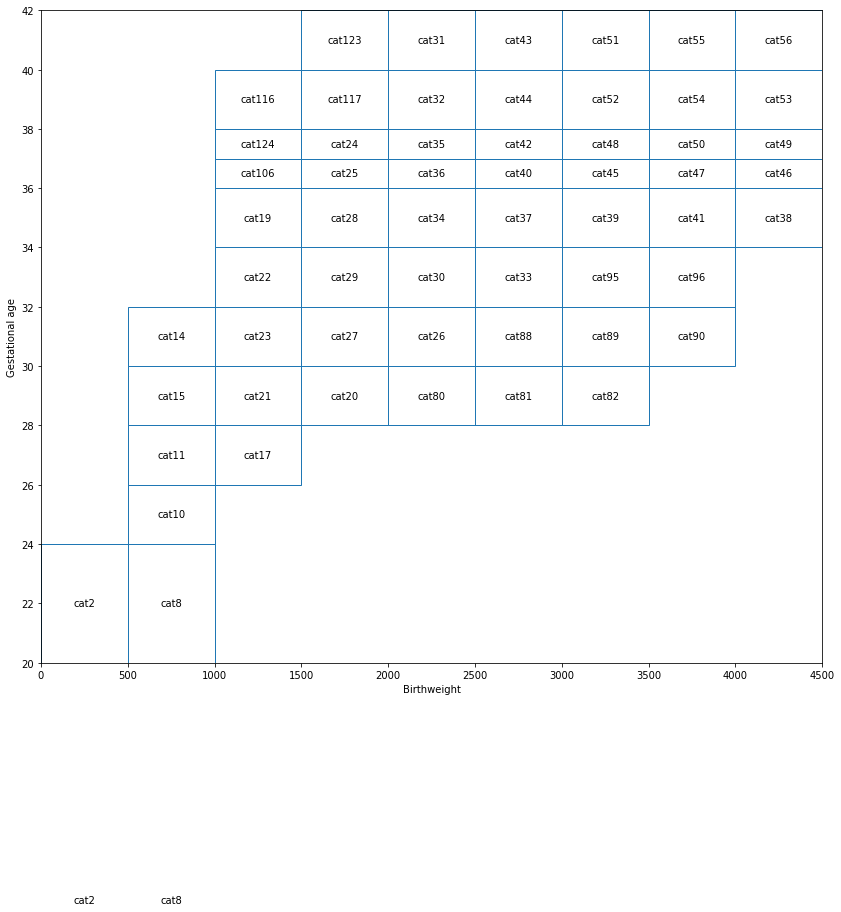

In [59]:
fig, ax = plt.subplots(figsize=(14,12))

def draw_category_rectangle(row):
    rectangle = Rectangle(
        (row.bw_start, row.ga_start),
        row.bw_width, row.ga_width,
#         label=row.lbwsg_category,
        color='tab:blue',
        fill=False
    )
    ax.add_patch(rectangle)

def add_category_label(row, xy=None):
    x, y = (row.bw_midpoint, row.ga_midpoint) if xy is None else xy
    ax.text(
        x, y, row.lbwsg_category,
        horizontalalignment='center',
        verticalalignment='center'
    )

cat_df.apply(draw_category_rectangle, axis=1)
cat_df.apply(add_category_label, axis=1)

for cat in ['cat2', 'cat8']:
    row = cat_df.loc[cat_df.lbwsg_category==cat,:].squeeze()
    add_category_label(row, xy=(row.bw_midpoint, row.ga_end-2))

ax.set_xlabel('Birthweight')
ax.set_xlim(0,4500)
ax.set_xticks(range(0,5000,500))
ax.set_ylabel('Gestational age')
ax.set_ylim(20,42)
ax.set_yticks(range(20,44,2))
plt.show()

In [46]:
for cat in ['cat2', 'cat8']:
    row = cat_df.loc[cat_df.lbwsg_category==cat,:].squeeze()
    print(type(row),row.bw_midpoint, row.ga_end-2,)

<class 'pandas.core.series.Series'> 250.0 22
<class 'pandas.core.series.Series'> 750.0 22


## Draw with gestational age horizontal

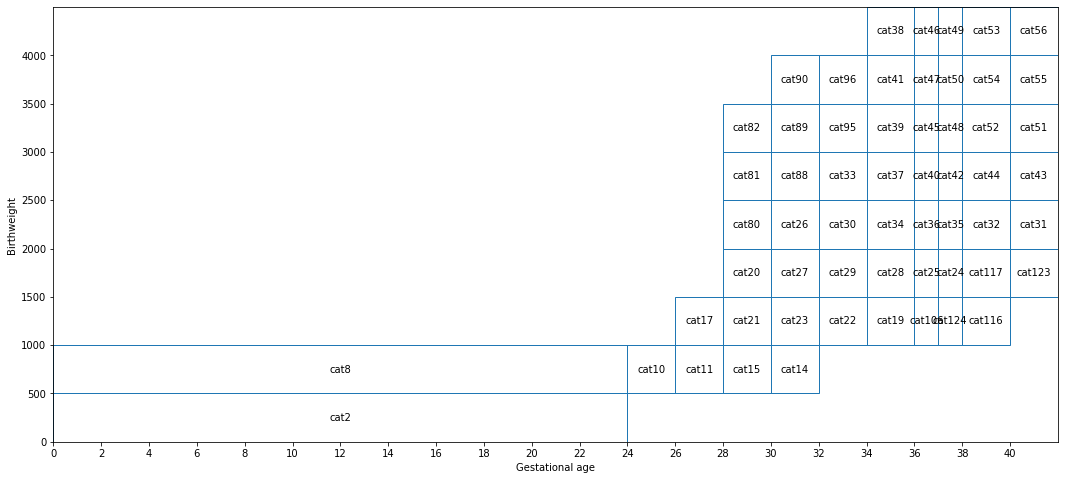

In [37]:
fig, ax = plt.subplots(figsize=(18,8))

def draw_rectangle(row):
    rectangle = Rectangle(
        (row.ga_start, row.bw_start),
        row.ga_width, row.bw_width,
#         label=row.lbwsg_category,
        color='tab:blue',
        fill=False
    )
    ax.add_patch(rectangle)
    ax.text(
        row.ga_midpoint, row.bw_midpoint, row.lbwsg_category,
        horizontalalignment='center',
        verticalalignment='center'
    )

cat_df.apply(draw_rectangle, axis=1)

ax.set_xlabel('Gestational age')
ax.set_xlim(0,42)
ax.set_xticks(range(0,42,2))
ax.set_ylabel('Birthweight')
ax.set_ylim(0,4500)
ax.set_yticks(range(0,4500,500))

plt.show()